<h1>Items</h1>
<ol>
<li>Measured progression of hot cache to cold cache. Benchmarks now only include hot samples.</li>
<li>Measured confidence interval in comparison between binary and interpolation search.</li>
<li>Refactored benchmarking code.</li>
<li>Plotted runtime against R^2 and mean absolute error on interpolation line on several random files of same size. Calculated R^2 to show how well error determines runtime.</li>
<li>Measured absolute distance for the median test input</li>
<li>SIMD Linear Search in one direction.</li>
</ol>
<h1>TODO</h1>
<ol>
<li>Bidirectional SIMD</li>
<li>Other SIMD improvments</li>
<li>Pruning Search</li>
<li>Recursive Interpolation Search (maybe not if SIMD helps enough)</li>
</ol>

In [4]:
import os, pandas
files = ['input.uniform.1000.' + str(n) for n in range(30)]
os.system('make -j p2iis ' + ' '.join(files))
algs = ['is', 'isSIMD']
cycles = { alg: [] for alg in algs}
for file in files:
    csv = pandas.read_csv(os.popen('./p2iis <' + file))
    for alg in algs:
        cycles[alg].append(csv[alg].mean())
numbers = {file: [float(s)
                  for s in open(file).read().splitlines()[1:]]
           for file in files}

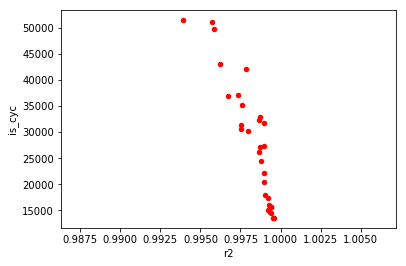

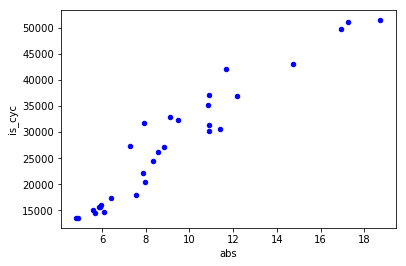

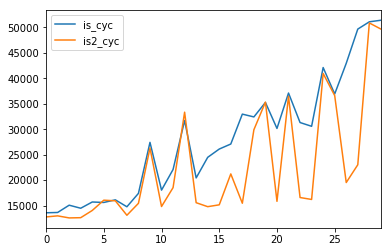

R^2 : absolute error --> cycles = 0.914287567689
R^2 : R^2 --> cycles = 0.822768675631
                    files     abs  is2_cyc
12  input.uniform.1000.12   5.585  12567.7
7    input.uniform.1000.7   5.669  12612.4
11  input.uniform.1000.11   4.821  12761.9
10  input.uniform.1000.10   4.874  12971.2
0    input.uniform.1000.0   6.067  13089.2
1    input.uniform.1000.1   5.850  14031.8
21  input.uniform.1000.21   8.328  14777.1
17  input.uniform.1000.17   7.559  14807.2
20  input.uniform.1000.20   8.580  15139.0
22  input.uniform.1000.22   6.418  15432.5
3    input.uniform.1000.3   9.097  15451.6
14  input.uniform.1000.14   7.973  15559.1
19  input.uniform.1000.19  10.885  15826.0
13  input.uniform.1000.13   5.928  15928.8
28  input.uniform.1000.28   5.921  16052.0
2    input.uniform.1000.2  11.413  16196.0
18  input.uniform.1000.18  10.904  16574.3
27  input.uniform.1000.27   7.884  18519.5
9    input.uniform.1000.9  14.729  19518.1
26  input.uniform.1000.26   8.856  21213.7
5    input

In [11]:
import sys, math
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import linregress

slopes = {file: (len(numbers[file]) - 1) / (max(numbers[file]) - min(numbers[file]))
          for file in files}
mins = {file: min(numbers[file]) for file in files}
estimates = {file: [math.floor((x - mins[file]) * slopes[file])
            for x in numbers[file]]
             for file in files}
r2_us = pandas.DataFrame({
    'files': files,
    'r2': [r2_score(range(len(numbers[file])), estimates[file])
      for file in files],
    'abs': [
        mean_absolute_error(
            range(len(numbers[file])),
            estimates[file])
        for file in files],
    'is_cyc': cycles['is'],
    'is2_cyc': cycles['isSIMD']})
plt.clf()
ax1 = r2_us.plot.scatter('r2', 'is_cyc', color='r')
r2_us.plot.scatter('abs', 'is_cyc', color='b')
r2_us.sort_values('abs').reset_index()[['is_cyc', 'is2_cyc']].plot()
plt.show()
_, _, r2_r, _, _ = linregress(r2_us['r2'], r2_us['is_cyc']) 
_, _, abs_r, _, _ = linregress(r2_us['abs'], r2_us['is_cyc'])

print("R^2 : absolute error --> cycles = " + str(abs_r**2))
print("R^2 : R^2 --> cycles = " + str(r2_r**2))
print(r2_us.sort_values('is2_cyc')[['files', 'abs', 'is2_cyc']])

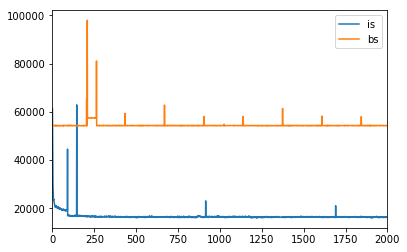

In [1]:
import os, pandas, math
import matplotlib.pyplot as plt
import numpy as np, scipy

N_LOAD = 2000
Z = 1.96 # Assume 95% confidence interval http://bit.ly/2qszG3k

os.system("make p2ibu; make input.uniform.1000.1")
p2ibu = pandas.read_csv(os.popen("./p2ibu 3000 < ./input.uniform.1000.1"))
hot = p2ibu.drop(range(N_LOAD))
errs = Z * hot.std() / math.sqrt(len(hot.index))

plt.clf()
# draw cold timings over time
p2ibu.drop(range(N_LOAD, len(p2ibu.index))).plot()
plt.show()

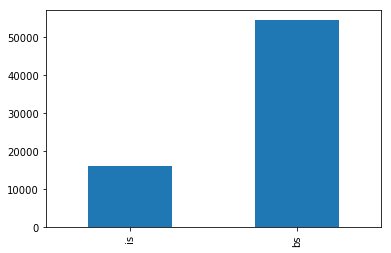

3.39032673145


In [2]:
# draw hot timings with standard deviation
fig, ax = plt.subplots()
hot.mean().plot.bar(yerr=errs, ax=ax)
plt.show()
print(hot.mean()['bs']/hot.mean()['is'])

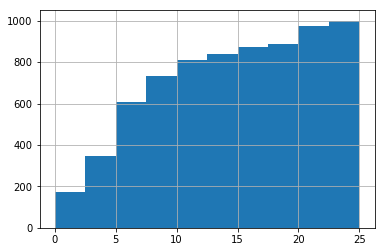

[15, 14, 4, 3, 8, 7, 23, 5, 5, 2, 8, 7, 1, 0, 3, 4, 16, 2, 3, 12, 2, 7, 7, 17, 14]
[7, 10, 2, 13, 10, 13, 1, 20, 8, 4, 7, 2, 7, 5, 8, 9, 21, 6, 4, 2, 6, 10, 23, 6, 9]


In [16]:
guess = pandas.read_csv("guess.csv")
diff = [abs(guess['x'][i] - guess['m'][i]) for i in range(len(guess['m']))]
pandas.Series(diff).hist(cumulative=True).plot()
plt.show()
print(diff[:25])
print(diff[-25:])